# Basin plotting

Plotting the basins with the rainfall gradient and the ksn values. 

Author:
MRSO

In [2]:
# Importing what I need, they are all installable from conda in case you miss one of them
import numpy as np
import numba as nb
import math
import zarr
import matplotlib.pyplot as plt

import helplotlib as hpl
import lsdtopytools as lsd
# Ignore that last
# %load_ext xsimlab.ipython
import cmcrameri.cm as cmc
import os
import pickle as pkl
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE" # Keep this or the code breaks because the HDF files aren't closed properly.


In [3]:
chi_with_rain = False


number_of_gradients = 11
rain_gradient = ['0', '1', '2','3', '4','5', '6','7', '8','9', '10']
file_path = '/exports/csce/datastore/geos/users/s1440040/projects/phd-fastscape/phd-fastscape/precipitation_analysis/models/'
file_names = ['snap2steady_discharge_grad_0.tif',
            'snap2steady_discharge_grad_1.tif',
			'snap2steady_discharge_grad_2.tif',
			'snap2steady_discharge_grad_3.tif',
			'snap2steady_discharge_grad_4.tif',
			'snap2steady_discharge_grad_5.tif',
			'snap2steady_discharge_grad_6.tif',
			'snap2steady_discharge_grad_7.tif',
			'snap2steady_discharge_grad_8.tif',
			'snap2steady_discharge_grad_9.tif',
			'snap2steady_discharge_grad_10.tif'
			]

rain_file_names = ['precip_snap2steady_discharge_grad_0.tif',
            'precip_snap2steady_discharge_grad_1.tif',
			'precip_snap2steady_discharge_grad_2.tif',
			'precip_snap2steady_discharge_grad_3.tif',
			'precip_snap2steady_discharge_grad_4.tif',
			'precip_snap2steady_discharge_grad_5.tif',
			'precip_snap2steady_discharge_grad_6.tif',
			'precip_snap2steady_discharge_grad_7.tif',
			'precip_snap2steady_discharge_grad_8.tif',
			'precip_snap2steady_discharge_grad_9.tif',
			'precip_snap2steady_discharge_grad_10.tif'
			]
area_threshold = 1e7

In [26]:
file_name_number = 1


In [44]:
dem_basins_with_rain = lsd.LSDDEM(path = file_path ,file_name = file_names[file_name_number])
dem_basins_with_rain.PreProcessing(filling = True, carving = True, minimum_slope_for_filling = 0.0001)

Loading the raster from file: /exports/csce/datastore/geos/users/s1440040/projects/phd-fastscape/phd-fastscape/precipitation_analysis/models/snap2steady_discharge_grad_1.tif
LOADING TOOK 0.016891956329345703
I am recasting your nodata values to -9999 (standard LSDTT)
PREPROC TOOK 0.001729726791381836
Alright, let me summon control upon the c++ code ...
Got it.
INGESTINGINTO CPP TOOK 0.0021479129791259766
FINALISATION TOOK 0.002844095230102539
lsdtopytools is now ready to roll!
Carving: implementation of Lindsay (2016) DOI: 10.1002/hyp.10648
Filling: implementation of Wang and Liu (2006): https://doi.org/10.1080/13658810500433453
Processing...
DEM ready for flow routines!


In [45]:
dem_basins_with_rain.CommonFlowRoutines(discharge = chi_with_rain, ingest_precipitation_raster = file_path+rain_file_names[file_name_number], precipitation_raster_multiplier = 8.76)

Processing common flow routines...
Done!


In [46]:
dem_basins_with_rain.ExtractRiverNetwork(method = "area_threshold", area_threshold_min = 200)
XY_basins_with_rain = dem_basins_with_rain.DefineCatchment(method="min_area", test_edges = False, min_area = area_threshold,max_area = 1e20, X_coords = [], Y_coords = [], 
	 coord_search_radius_nodes = 30, coord_threshold_stream_order = 3)
dem_basins_with_rain.GenerateChi(theta=0.45,A_0 = 1)

In [47]:
# if error comes up, just ignore, it works fine
dem_basins_with_rain.ksn_MuddEtAl2014(target_nodes=30, n_iterations=60, skip=1)
df_basins_with_rain = dem_basins_with_rain.df_ksn
total_basins = len(XY_basins_with_rain['X'])

I have generated ksn for the specified region!
Let me just save the result to the hdf5 file to keep track


In [48]:
# get rid of the entries corresponding to the edge basins

df_basins_with_rain_new = df_basins_with_rain[(df_basins_with_rain.basin_key != 0)&(df_basins_with_rain.basin_key != 12)&(df_basins_with_rain.basin_key != 11)]

In [49]:
total_basins_thresh = len(XY_basins_with_rain['X'][1:-3])

In [ ]:
fig, ax = hpl.mkfig_simple_bold(fontsize_major = 18, fontsize_minor= 14, family = "DejaVu Sans" , figsize = (5,6))


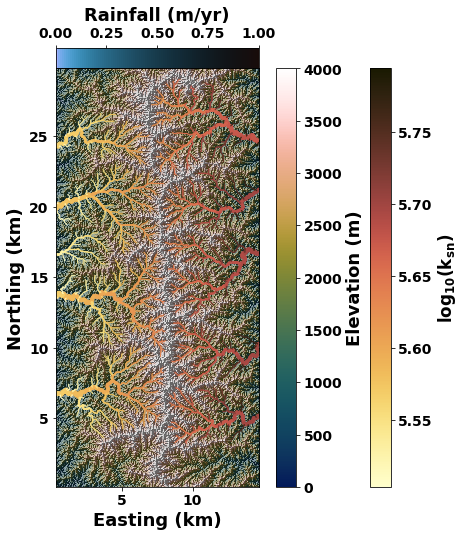

In [63]:
import matplotlib as mpl
import matplotlib.colors as mcolors
# plt.rc('text', usetex=True)
# plt.rcParams['text.latex.preamble'] = [r'\boldmath']
from mpl_toolkits.axes_grid1 import make_axes_locatable
#plt.rcParamaxes.labelweight
plt.rcParams['axes.labelweight'] = 'bold'
#plt.rcParams['fig.labelweight'] = 'bold'

df_basins_with_rain = dem_basins_with_rain.df_ksn
cmap = cmc.hawaii#plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
#cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, total_basins_thresh, total_basins_thresh+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# make the scatter
fig,ax = lsd.quickplot.get_basemap(
    dem_basins_with_rain, # which dem object to plot
    figsize = (6,7), # figsize
    cmap = cmc.batlowW, # colormap for elevation
    cmin = 0, cmax = 4000, # color limit for elevation (None for defaulting to min max)
    hillshade = True, # Hillshade ?
	alpha_hillshade = 0.6,normalise_HS = True, # options
	hillshade_cmin = 0, hillshade_cmax = 1, # HS cmap boundaries
    colorbar = True, #Plotting cbar?
	fig = None, ax = None, colorbar_label = 'Elevation (m)', colorbar_ax = None, fontsize_ticks = 8) # advanced usage
fig.set_facecolor("w")
# This is a hack to size my river points function of drainage area to look nice
# if the contrast is too pronounced, you can use log10
#size = lsd.quickplot_utilities.size_my_points(np.log10(df_basins_with_rain.drainage_area.values), 1,10)
# df_basins_with_rain_new = df_basins_with_rain_new.drop(df_basins_with_rain_new[df_basins_with_rain_new['basin_key'] == 10].index)
# df_basins_with_rain_new = df_basins_with_rain_new.drop(df_basins_with_rain_new[df_basins_with_rain_new['m_chi'] <300].index)
df_basins_with_rain_new = df_basins_with_rain_new.drop(df_basins_with_rain_new[df_basins_with_rain_new['m_chi'] <200].index) # for rain of 1m/yr
size = lsd.quickplot_utilities.size_my_points(df_basins_with_rain_new.drainage_area.values,1, 20)
color_map = cmc.lajolla
scat = ax.scatter(df_basins_with_rain_new.x,df_basins_with_rain_new.y, c=np.log(df_basins_with_rain_new.m_chi), cmap = color_map, s = size, lw = 0, zorder = 2)#, cmap = cmap)
# cbar = plt.colorbar(scat, ax=ax, orientation='horizontal')
# cbar.ax.set_ylabel(r'$log_{10}(k_{sn})$', size=21, rotation=0)
plt.margins(x=-0.02, y=-0.005)
cax = ax.inset_axes([1.55, 0, 0.1,  1])
cbar = plt.colorbar(scat, orientation='vertical', cax=cax)
#cbar.ax.set_title(r'$log_{10}k_{sn}$', fontsize = 18)
# cbar.set_label(r'$log_{10}(k_{sn})$', size=18,fontweight=1000)
#cbar.ax.set_ylabel(r'$log_{10}(k_{sn})$', weight = 'bold')
cbar.set_label(label=r'$\mathbf{log_{10}(k_{sn})}$', size='large', weight='bold')
cmap_blues = mcolors.LinearSegmentedColormap.from_list("", cmc.berlin.colors[:int(256/2)],gamma=0.5,N=100)
colors_blues = [mcolors.rgb2hex(cmap_blues(i)) for i in range(cmap_blues.N)]
# create normalization instance



norm = plt.Normalize(vmin=0, vmax=1) 
# create a scalarmappable from the colormap
sm = plt.cm.ScalarMappable(cmap=cmap_blues, norm=norm)    
sm.set_array([])  
cbaxes = ax.inset_axes([0, 1, 1, 0.05],zorder=4) # [x0, y0, width, height]
cbar = ax.figure.colorbar(sm, cax=cbaxes, orientation="horizontal", shrink = 0.1)#, fontsize = 14)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.set_title('Rainfall (m/yr)', rotation=0, fontsize = 18, weight = 'bold')

base_path = '/exports/csce/datastore/geos/users/s1440040/projects/phd-fastscape/phd-fastscape/model_outputs_for_statistics/'
plt.savefig(base_path+'basin_map_discharge_incision_grad_1.pdf', dpi=400,  bbox_inches='tight')